#Importar Librerias

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import mysql.connector
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Cargar las variables de entorno del archivo .env

In [2]:
load_dotenv()
db_host = os.getenv('DB_HOST')
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_name = os.getenv('DB_NAME')

# Conectar a la base de datos MySQL

In [3]:
conn = mysql.connector.connect(
    host=db_host,
    user=db_user,
    password=db_password,
    database=db_name
)

# Ejecutar la consulta SQL

In [4]:
query = """
SELECT seller_id, sku, release_date
FROM production_db.products
WHERE seller_id <> 1
  AND release_date >= DATE_SUB(CURDATE(), INTERVAL 1 YEAR)
  AND created_at < DATE_FORMAT(CURDATE(), '%Y-%m-01');
"""
df = pd.read_sql(query, conn)

conn.close()

### Cargar los datos y realizar las transformaciones necesarias

In [5]:
df['release_date'] = pd.to_datetime(df['release_date'], format='%Y-%m-%d', errors='coerce')
df['period'] = df['release_date'].dt.strftime('%Y-%m')
df['cohort_group'] = df.groupby('seller_id')['release_date'].transform('min').dt.strftime('%Y-%m')
df.head()

,seller_id,sku,release_date,period,cohort_group
0,26522,VTR25249R20S26522,2024-05-05 17:00:03,2024-05,2024-05
1,21976,VTR28469R84S21976,2024-04-23 18:57:43,2024-04,2024-01
2,7049,VTR31515R60S7049,2024-06-13 15:00:08,2024-06,2024-05
3,31985,VTR31572R72S31985,2023-12-13 14:45:51,2023-12,2023-12
4,9386,VTR34550R25S9386,2024-04-17 23:27:01,2024-04,2023-12


In [6]:
df.to_csv('data_product_seller.csv', index=True)

# Agrupar por cohortes y períodos

In [7]:
grouped = df.groupby(['cohort_group', 'period'])
cohorts = grouped.agg({'seller_id': pd.Series.nunique})
cohorts.head()

seller_id
cohort_group period            
2023-12      2023-12        281
             2024-01         41
             2024-02         31
             2024-03         30
             2024-04         33

# Calcular tamaño del grupo de cohortes

In [8]:
cohort_group_size = cohorts['seller_id'].groupby(level=0).first()
cohort_group_size.head()

cohort_group
2023-12    281
2024-01    249
2024-02    240
2024-03    294
2024-04    796
Name: seller_id, dtype: int64

# Crear matriz de retención en enteros y en porcentaje

In [9]:
retencion_int = cohorts['seller_id'].unstack(0).fillna(0)  # Datos de retención en enteros
retencion_int[retencion_int == 0] = np.nan  # Reemplazar ceros con NaN
retencion_int.head()

cohort_group,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11
period,,,,,,,,,,,,
2023-12,281.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01,41.0,249.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02,31.0,58.0,240.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03,30.0,46.0,35.0,294.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04,33.0,33.0,38.0,33.0,796.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
retencion_percent = retencion_int.divide(cohort_group_size, axis=1)  # Datos de retención en porcentaje
retencion_percent.head()

cohort_group,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11
period,,,,,,,,,,,,
2023-12,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01,0.145907,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02,0.110320,0.232932,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03,0.106762,0.184739,0.145833,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04,0.117438,0.132530,0.158333,0.112245,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Exportar datos a CSV

In [11]:
mes_actual = (datetime.now() - relativedelta(months=1)).strftime('%B')

retencion_int_t = retencion_int.T
retencion_percent_t = retencion_percent.T

retencion_int_t.to_csv(f'datareten_int_product_{mes_actual}.csv', index=True)
retencion_percent_t.to_csv(f'datareten_percent_product_{mes_actual}.csv', index=True)

# Configurar tamaño de figura y crear el primer gráfico (porcentaje)

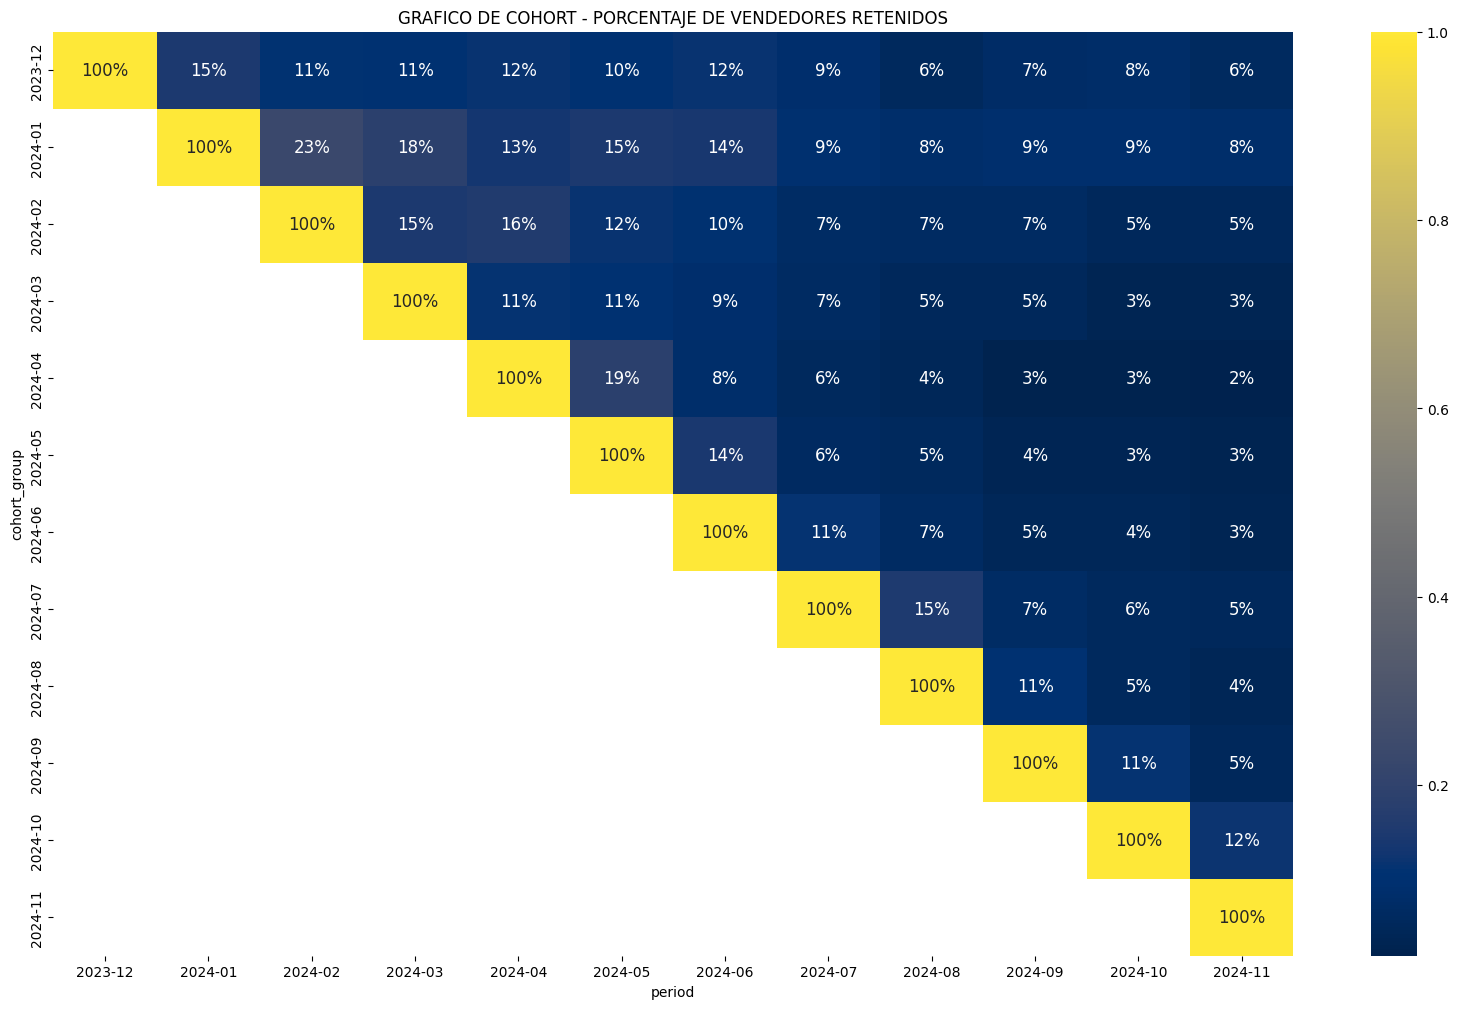

In [12]:
porcentaje = retencion_percent.T

plt.figure(figsize=(20, 12))
plt.title('GRAFICO DE COHORT - PORCENTAJE DE VENDEDORES RETENIDOS')
sns.heatmap(data=porcentaje,
            annot=True,
            fmt=".0%",  # Formato de porcentaje sin decimales
            annot_kws={'size': 12},  # Tamaño de las anotaciones
            cbar=True,
            cmap='cividis',
            linewidths=0)  # Sin bordes internos
plt.savefig(f'datareten_percent_products_publications_{mes_actual}.png')
plt.show()

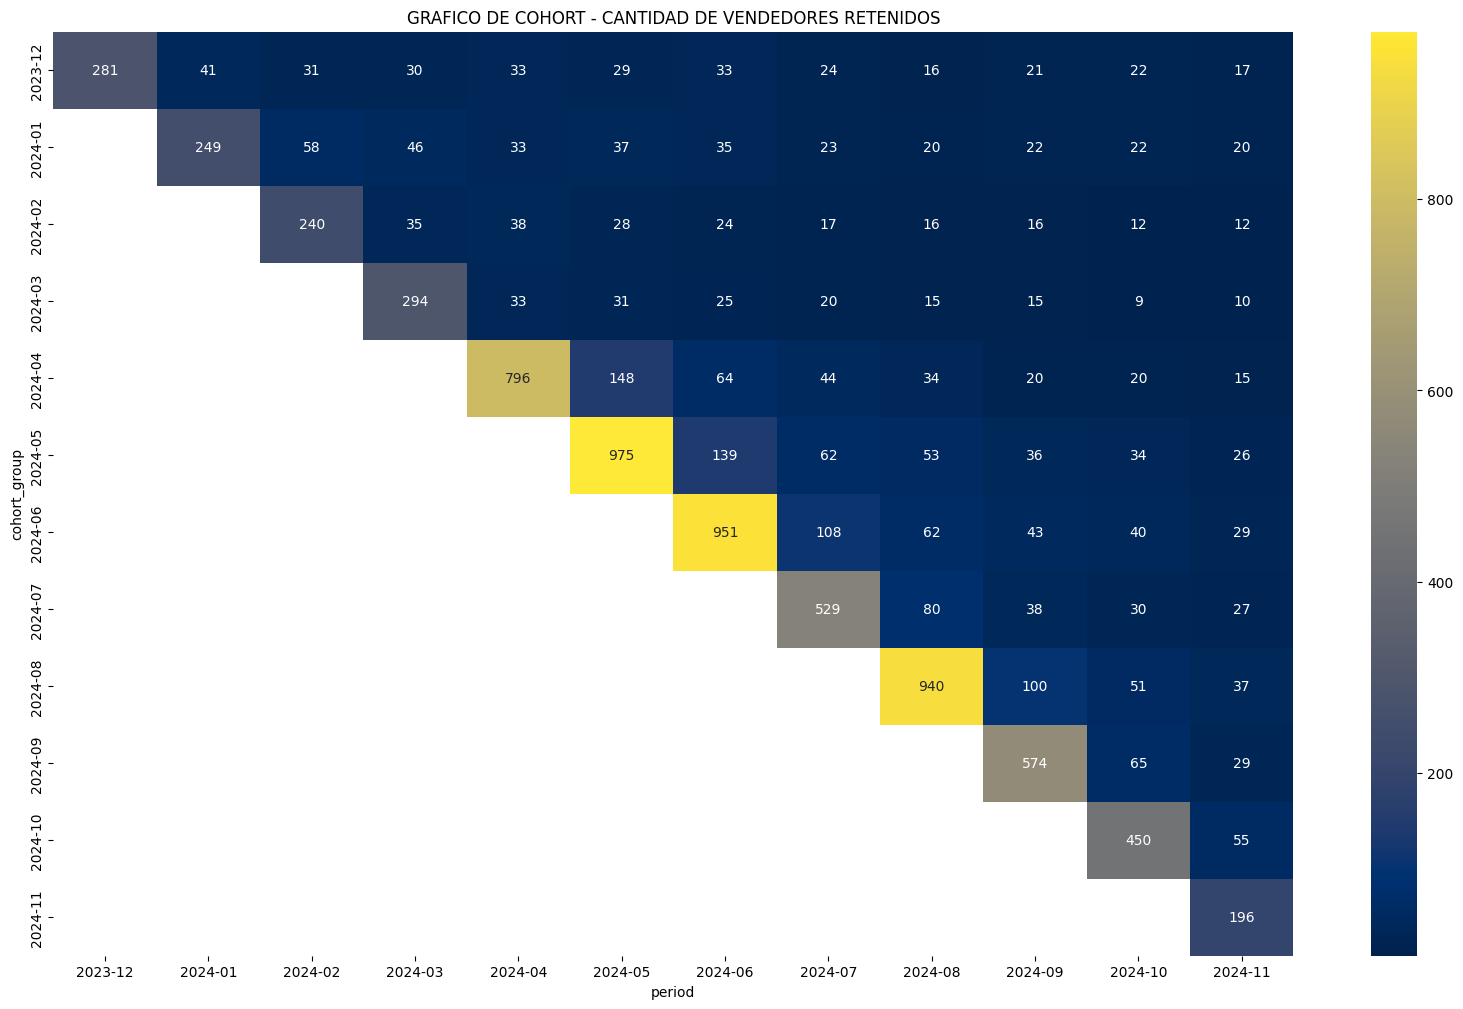

In [13]:
mask = retencion_int == 0

# Configura tamaño de figura y crea el gráfico
plt.figure(figsize=(20, 12))
plt.title('GRAFICO DE COHORT - CANTIDAD DE VENDEDORES RETENIDOS')
sns.heatmap(data=retencion_int.T,
            annot=True,
            fmt=".0f",  # Formato para números float sin decimales
            annot_kws={'size': 10},  # Tamaño de las anotaciones
            cbar=True,
            cmap='cividis',
            linewidths=0)  # Sin bordes internos
plt.savefig(f'datareten_int_products_publications_{mes_actual}.png')
plt.show()